In [49]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

In [51]:
# load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

In [53]:
print("train data:",x_train.shape)
print("test data:",x_test.shape)

train data: (60000, 28, 28)
test data: (10000, 28, 28)


In [55]:
# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

In [57]:
print("train after reshape:",x_train.shape)
print("test after reshape:",x_test.shape)

train after reshape: (60000, 28, 28, 1)
test after reshape: (10000, 28, 28, 1)


In [59]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [61]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [63]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
    kernel_size=kernel_size,
    activation='relu',
    strides=2,
    padding='same')(x)

In [65]:
# shape info needed to build decoder model
# so we don't do hand computation
# the input to the decoder's first
# Conv2DTranspose will have this shape
# shape is (7, 7, 64) which is processed by
# the decoder back to (28, 28, 1)
shape = K.int_shape(x)
shape

(None, 7, 7, 64)

In [67]:
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
# instantiate encoder model
encoder = Model(inputs,
latent,
name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 16)             │        50,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,008 (269.56 KB)

 Trainable params: 69,008 (269.56 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
plot_model(encoder,
                    to_file='encoder.png',
                    show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [71]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape (7, 7, 64) that was earlier saved
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [73]:
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
            x = Conv2DTranspose(filters=filters, kernel_size=kernel_size,activation='relu',strides=2,  padding='same')(x)

In [75]:
# reconstruct the input
outputs = Conv2DTranspose(filters=1,
                                    kernel_size=kernel_size,
                                    activation='sigmoid',
                                    padding='same',
                                    name='decoder_output')(x)

In [77]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,993 (425.75 KB)

 Trainable params: 108,993 (425.75 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
plot_model(decoder, to_file='decoder.png', show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [81]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                            decoder(encoder(inputs)),
                            name='autoencoder')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16)             │        69,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       108,993 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,001 (695.32 KB)

 Trainable params: 178,001 (695.32 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
plot_model(autoencoder,
                        to_file='autoencoder.png',
                        show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [85]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

In [87]:
# train the autoencoder
autoencoder.fit(x_train,
                        x_train,
                        validation_data=(x_test, x_test),
                        epochs=3,
                        batch_size=batch_size)

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - loss: 0.0417 - val_loss: 0.0103
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 27ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 49s 26ms/step - loss: 0.0087 - val_loss: 0.0081


In [89]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [91]:
# display the 1st 8 test input and decoded images
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

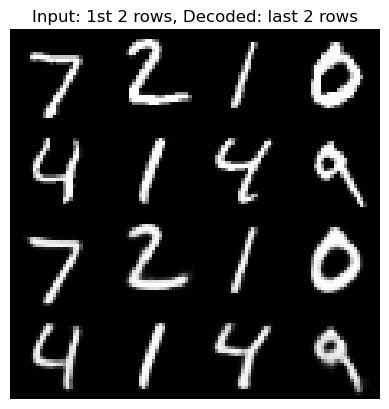

In [93]:
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()